In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn import preprocessing
import itertools
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%load_ext autotime

## DataLoader

In [2]:
### handle the dataset
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)
    return test_loader

time: 472 µs


## Arrays and Functions

In [3]:
Sbox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71,
        240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216,
        49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160,
        82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208,
        239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188,
        182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96,
        129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211,
        172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186,
        120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97,
        53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140,
        161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22]

HW_byte = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2,
            3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2, 2, 3, 2, 3,
            3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3,
            4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
            3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5,
            6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4,
            4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5,
            6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]

### To train a network 
def train(epoch, model, freeze_BN = False):
    """
    - epoch : the current epoch
    - model : the current model   
    - freeze_BN : whether to freeze batch normalization layers
    """
    if freeze_BN:
        model.eval() # enter eval mode to freeze batch normalization layers
    else:
        model.train() # enter training mode 
    # Instantiate the Iterator
    iter_source = iter(source_train_loader)
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        source_data, source_label = iter_source.next()
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        optimizer.zero_grad()
        source_preds = model(source_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        correct_batch = preds.eq(source_label.data.view_as(preds)).sum()
        loss = clf_criterion(source_preds, source_label)
        # optimzie the cross-entropy loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, float(correct_batch) * 100. /batch_size))
            
### validation 
def validation(model):
    # enter evaluation mode
    model.eval()
    valid_loss = 0
    # the number of correct prediction
    correct_valid = 0
    clf_criterion = nn.CrossEntropyLoss()
    for data, label in source_valid_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        valid_preds = model(data)
        # sum up batch loss
        valid_loss += clf_criterion(valid_preds, label) 
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        # get the number of correct prediction
        correct_valid += pred.eq(label.data.view_as(pred)).cpu().sum()
    valid_loss /= len(source_valid_loader)
    valid_acc = 100. * correct_valid / len(source_valid_loader.dataset)
    print('Validation: loss: {:.4f}, accuracy: {}/{} ({:.6f}%)'.format(
        valid_loss.data, correct_valid, len(source_valid_loader.dataset),
        valid_acc))
    return valid_loss, valid_acc

### test/attack
def test(model, device_id, disp_GE=True,disp_MAT=True, model_flag='pretrained'):
    """
    - model : the current model 
    - device_id : id of the tested device
    - disp_GE : whether to attack/calculate guessing entropy (GE)
    - model_flag : a string for naming GE result
    """
    # enter evaluation mode
    model.eval()
    test_loss = 0
    # the number of correct prediction
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()
    if device_id == source_device_id: # attack on the source domain
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else: # attack on the target domain
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02
    # Initialize the prediction and label lists(tensors)
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')
    for data, label in test_loader:
        if cuda:
            data, label = data.cuda(), label.cuda()
        data, label = Variable(data), Variable(label)
        test_preds = model(data)
        # sum up batch loss
        test_loss += clf_criterion(test_preds, label) 
        # get the index of the max probability
        pred = test_preds.data.max(1)[1]
        # get the softmax results for attack/showing guessing entropy
        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch*batch_size:(epoch+1)*batch_size, :] =softmax(test_preds)
        # get the predictions (predlist) and real labels (lbllist) for showing confusion matrix
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        # get the number of correct prediction
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1
    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    if disp_MAT:
        # get the confusion matrix
        confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
        # show the confusion matrix
        plot_sonfusion_matrix(confusion_mat, classes = range(class_num),model_flag=model_flag)
    # show the guessing entropy and success rate
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)
        
        
        

### fine-tune a pre-trained model
def CDP_train(epoch, model):
    """
    - epoch : the current epoch
    - model : the current model  
    """
    # enter evaluation mode to freeze the BN and dropout (if have) layer when fine-tuning
    model.eval()
    # Instantiate the Iterator for source tprofiling traces
    iter_source = iter(source_train_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    # train on each batch of data
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        optimizer.zero_grad()
        # get predictions and MMD loss
        source_preds, mmd_loss = model(source_data, target_data)
        preds = source_preds.data.max(1, keepdim=True)[1]
        # get classification loss on source doamin
        clf_loss = clf_criterion(source_preds, source_label)
        # the total loss function
        loss = clf_loss + lambda_*mmd_loss
        # optimzie the total loss
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\ttotal_loss: {:.6f}\tclf_loss: {:.6f}\tmmd_loss: {:.6f}'.format(
                epoch, i * len(source_data), len(source_train_loader) * batch_size,
                100. * i / len(source_train_loader), loss.data, clf_loss.data, mmd_loss.data))

### Validation for fine-tuning phase          
def CDP_validation(model):
    # enter evaluation mode
    clf_criterion = nn.CrossEntropyLoss()
    model.eval()
    # Instantiate the Iterator for source validation traces
    iter_source = iter(source_valid_loader)
    # Instantiate the Iterator for target traces
    iter_target = iter(target_finetune_loader)
    num_iter_target = len(target_finetune_loader)
    finetune_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    for i in range(num_iter_target):
        finetune_trace_all[i,:,:,:], _ = iter_target.next()
    # get the number of batches
    num_iter = len(source_valid_loader)
    # the classification loss
    total_clf_loss = 0
    # the MMD loss
    total_mmd_loss = 0
    # the total loss
    total_loss = 0
    # the number of correct prediction
    correct = 0
    for i in range(1, num_iter+1):
        # get traces and labels for source domain
        source_data, source_label = iter_source.next()
        # get traces for target domain
        target_data = finetune_trace_all[(i-1)%num_iter_target,:,:,:]
        if cuda:
            source_data, source_label = source_data.cuda(), source_label.cuda()
            target_data = target_data.cuda()
        source_data, source_label = Variable(source_data), Variable(source_label)
        target_data = Variable(target_data)
        valid_preds, mmd_loss = model(source_data, target_data)
        clf_loss = clf_criterion(valid_preds, source_label) 
        # sum up batch loss
        loss = clf_loss + lambda_*mmd_loss
        total_clf_loss += clf_loss
        total_mmd_loss += mmd_loss
        total_loss += loss
        # get the index of the max probability
        pred = valid_preds.data.max(1)[1] 
        correct += pred.eq(source_label.data.view_as(pred)).cpu().sum()
    total_loss /= len(source_valid_loader)
    total_clf_loss /= len(source_valid_loader)
    total_mmd_loss /= len(source_valid_loader)
    print('Validation: total_loss: {:.4f}, clf_loss: {:.4f}, mmd_loss: {:.4f}, accuracy: {}/{} ({:.2f}%)'.format(
        total_loss.data, total_clf_loss, total_mmd_loss, correct, len(source_valid_loader.dataset),
        100. * correct / len(source_valid_loader.dataset)))
    return total_loss

### kernel function
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    # |x-y|
    L2_distance = ((total0-total1)**2).sum(2) 
    
#     ## coustmoized by HL
#     print(f"Ls-distance {L2_distance}")
    
    # bandwidth
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    
#     ## coustmoized by HL
#     print(f"bandwidth {bandwidth}")
    
    # take the current bandwidth as the median value, and get a list of bandwidths (for example, when bandwidth is 1, we get [0.25,0.5,1,2,4]). 
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    # exp(-|x-y|/bandwidth)
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for \
                  bandwidth_temp in bandwidth_list]
    
#     ## coustmoized by HL
#     print(f"kernel_val {kernel_val}")
    
    # return the final kernel matrix
    return sum(kernel_val)

### MMD loss function based on guassian kernels
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    - source : source data
    - target : target data
    - kernel_mul : multiplicative step of bandwidth (sigma)
    - kernel_num : the number of guassian kernels
    - fix_sigma : use a fix value of bandwidth
    """
    loss = 0.0
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,kernel_mul=kernel_mul,kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size] # Source<->Source
    YY = kernels[batch_size:, batch_size:] # Target<->Target
    XY = kernels[:batch_size, batch_size:] # Source<->Target
    YX = kernels[batch_size:, :batch_size] # Target<->Source
    loss = torch.mean(XX + YY - XY -YX)
    
#     ## coustmoized by HL
#     print("kerneks {kernels}")
#     print(f"loss {loss}")
    
    return loss

### show the guessing entropy and success rate
def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 100 attacks 
    num_averaged = 100
    # max trace num for attack
    trace_num_max = 500
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    if device_id == target_device_id: # attack on the target domain
        plaintext = plaintexts_target
    elif device_id == source_device_id: # attack on the source domain
        plaintext = plaintexts_source
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index = list(range(plaintext.shape[0]))
        
#         ## customized by HL
#         print(f"random_index shape {len(random_index)}, max value {max(random_index)}, min value {min(random_index)}")
        
        random.shuffle(random_index)
        random_index = random_index[0:trace_num_max]
        
#         ## customized by HL
#         print(f"random_index shape after slicing {len(random_index)}, max value {max(random_index)}, min value {min(random_index)}")
        
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                sout = Sbox[initialState]
                if labeling_method == 'identity':
                    label = sout
                elif labeling_method == 'hw':
                    label = HW_byte[sout]
                score_mat[i, key_guess] = preds[random_index[i], label]
        score_mat = np.log(score_mat + 1e-40)
        
#         ## customized by HL
#         print(f"score_mat {score_mat}")
        
        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
    guessing_entropy = np.mean(guessing_entropy,axis=0)
#     plt.figure(figsize=(12,4))
#     plt.subplot(1, 2, 1)
#     p1, = plt.plot(guessing_entropy[0:trace_num_max],color='red')
#     plt.xlabel('Number of trace')
#     plt.ylabel('Guessing entropy')
#     #np.save('./results/entropy_'+ labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, guessing_entropy)
#     plt.subplot(1, 2, 2)       
#     success_flag = np.sum(success_flag, axis=0)
#     success_rate = success_flag/num_averaged 
#     p2, = plt.plot(success_rate[0:trace_num_max], color='red')
#     plt.xlabel('Number of trace')
#     plt.ylabel('Success rate')
#     plt.savefig('./results/ge_%s.eps' % model_flag)
#     plt.show()
#     #np.save('./results/success_rate_' + labeling_method + '_{}_to_{}_'.format(source_device_id, device_id) + model_flag, success_rate)

    ## customized by HL
    ## only plot guess entry
    plt.figure(figsize=(8,6))
    p1, = plt.plot(guessing_entropy[0:trace_num_max],color='red')
    plt.xlabel('Number of trace')
    plt.ylabel('Key Rank')  
    plt.savefig('./results/ge_%s.eps' % model_flag)
    plt.show()

### show the confusion matrix 
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues,model_flag=None):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')   
    plt.ylim((len(classes)-0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')
    plt.savefig('./results/cm_%s.eps' %model_flag)
    plt.show()

time: 28.1 ms


## Setups

In [4]:
source_device_id = 1
target_device_id = 2
real_key_01 = 0x01 # key of the source domain
real_key_02 = 0x02 # key of the target domain
lambda_ = 0.1 # Penalty coefficient
labeling_method = 'hw' # labeling of trace, default 'hw'
preprocess = 'horizontal_standardization' # preprocess method, default: 'horizontal_standardization'
batch_size = 100
total_epoch = 100  # default 100
finetune_epoch = 15 # epoch number for fine-tuning
lr = 0.001 # learning rate
log_interval = 40 # epoch interval to log training information
train_num = 20000
valid_num = 5000
source_test_num = 5000
target_finetune_num = 100
target_test_num = 4500
trace_offset = 0
trace_length = 500   ##default 500
source_file_path = './Data/device01/'
target_file_path = './Data/device02/'
no_cuda =False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9
    
# to load traces and labels
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

## customized by HL
# X_tuning_target = np.load(target_file_path + 'X_tuning.npy')
# Y_tuning_target = np.load(target_file_path + 'Y_tuning_hw.npy')

# to load plaintexts
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
plaintexts_target = plaintexts_target[target_finetune_num:target_finetune_num+target_test_num]


# preprocess of traces
if preprocess == 'horizontal_standardization':
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn)/std

    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn)/std
    
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn)/std  
    
#     mn = np.repeat(np.mean(X_tuning_target, axis=1, keepdims=True), X_tuning_target.shape[1], axis=1)
#     std = np.repeat(np.std(X_tuning_target, axis=1, keepdims=True), X_tuning_target.shape[1], axis=1)
#     X_tuning_target = (X_tuning_target - mn)/std
    
#     ## customized by HL
#     print(f"{preprocess} pre-processed training source data: {X_train_source}")
#     print(f"{preprocess} pre-processed attacking target data: {X_attack_target}")
    
elif preprocess == 'horizontal_scaling':
    lower, upper = -1,1 # default, lower=-1, upper=1
    scaler = preprocessing.MinMaxScaler(feature_range=(lower, upper)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    scaler = preprocessing.MinMaxScaler(feature_range=(lower, upper)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T
    
    scaler = preprocessing.MinMaxScaler(feature_range=(lower, upper)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T
    
#     scaler = preprocessing.MinMaxScaler(feature_range=(lower, upper)).fit(X_tuning_target.T)
#     X_tuning_target = scaler.transform(X_tuning_target.T).T

#     ## customized by HL
#     print(f"{preprocess} pre-processed training source data: {X_train_source}")
#     print(f"{preprocess} pre-processed attacking target data: {X_attack_target}")
    
    
# parameters of data loader
kwargs_source_train = {
        'trs_file': X_train_source[0:train_num,:],
        'label_file': Y_train_source[0:train_num],
        'trace_num':train_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_valid = {
        'trs_file': X_train_source[train_num:train_num+valid_num,:],
        'label_file': Y_train_source[train_num:train_num+valid_num],
        'trace_num':valid_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_source_test = {
        'trs_file': X_attack_source,
        'label_file': Y_attack_source,
        'trace_num':source_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target_finetune = {
        'trs_file': X_attack_target[0:target_finetune_num,:],
        'label_file': Y_attack_target[0:target_finetune_num],
        'trace_num':target_finetune_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}
kwargs_target = {
        'trs_file': X_attack_target[target_finetune_num:target_finetune_num+target_test_num, :],
        'label_file': Y_attack_target[target_finetune_num:target_finetune_num+target_test_num],
        'trace_num':target_test_num,
        'trace_offset':trace_offset,
        'trace_length':trace_length,
}

# ## customized by HL
# kwargs_target_finetune = {
#         'trs_file': X_tuning_target,
#         'label_file': Y_tuning_target,
#         'trace_num':target_finetune_num,
#         'trace_offset':trace_offset,
#         'trace_length':trace_length,
# }
# kwargs_target = {
#         'trs_file': X_attack_target,
#         'label_file': Y_attack_target,
#         'trace_num':target_test_num,
#         'trace_offset':trace_offset,
#         'trace_length':trace_length,
# }


source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_finetune_loader = load_training(batch_size, kwargs_target_finetune)
target_test_loader = load_testing(batch_size, kwargs_target)
print('Load data complete!')

Load data complete!
time: 2.89 s


## Models

In [5]:
### the pre-trained model
class Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1 (inputsize=500-->(batchsize,64); inputsize=1000-->(batchsize,192))
        self.classifier_1 = nn.Sequential(
#             nn.Linear(192, 20),
            nn.Linear(64, 20), # sjtu parameter
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

    # how the network runs
    def forward(self, input):
        x = self.features(input)
        x = x.view(x.size(0), -1)
        x = self.classifier_1(x)
        output = self.final_classifier(x)
        return output

### the fine-tuning model
class CDP_Net(nn.Module):
    def __init__(self, num_classes=class_num):
        super(CDP_Net, self).__init__()
        # the encoder part
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=1),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # the fully-connected layer 1
        self.classifier_1 = nn.Sequential(
            #nn.Linear(192, 20), #ours
            nn.Linear(64, 20), # sjtu
            nn.ReLU(inplace=True),
        )
        # the output layer
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )
        
    # how the network runs
    def forward(self, source, target):
        mmd_loss = 0
        #source data flow
        source = self.features(source)
        source_0 = source.view(source.size(0), -1)
        source_1 = self.classifier_1(source_0)
        
        #target data flow
        target = self.features(target)
        target = target.view(target.size(0), -1)
        mmd_loss += mmd_rbf(source_0, target)
        target = self.classifier_1(target)
        mmd_loss += mmd_rbf(source_1, target)
        
        result = self.final_classifier(source_1)
        return result, mmd_loss

time: 668 µs


## Train a pre-trained model if needed

In [6]:
pre_trained = True

time: 286 ms


In [7]:
if pre_trained:
    # create a network 
    pretrained_model = Net(num_classes=class_num)
    print('Construct model complete')
    if cuda:
        pretrained_model.cuda()
    # initiate a big enough loss
    min_loss = 1000
    optimizer = optim.Adam([
        {'params': pretrained_model.features.parameters()},
        {'params': pretrained_model.classifier_1.parameters()},
        {'params': pretrained_model.final_classifier.parameters()}
    ], lr=lr)
    # start training
    for epoch in range(1,total_epoch+1):
        print(f'Train Epoch {epoch}:')
        train(epoch,pretrained_model,freeze_BN=False)
        with torch.no_grad():
            valid_loss,valid_acc = validation(pretrained_model)
            if valid_loss < min_loss:
                min_loss = valid_loss
                torch.save({
                'epoch': epoch,
                'model_state_dict': pretrained_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, './models/pre-trained_device{}.pth'.format(source_device_id))
    torch.save({
        'epoch': epoch,
        'model_state_dict': pretrained_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, './models/last_pre-trained_device{}.pth'.format(source_device_id))
    

time: 38.9 ms


## Performance of the pre-trained model

Construct model complete
Result on source device:
Target test loss: 0.2518, Target test accuracy: 36032/40000 (90.08%)



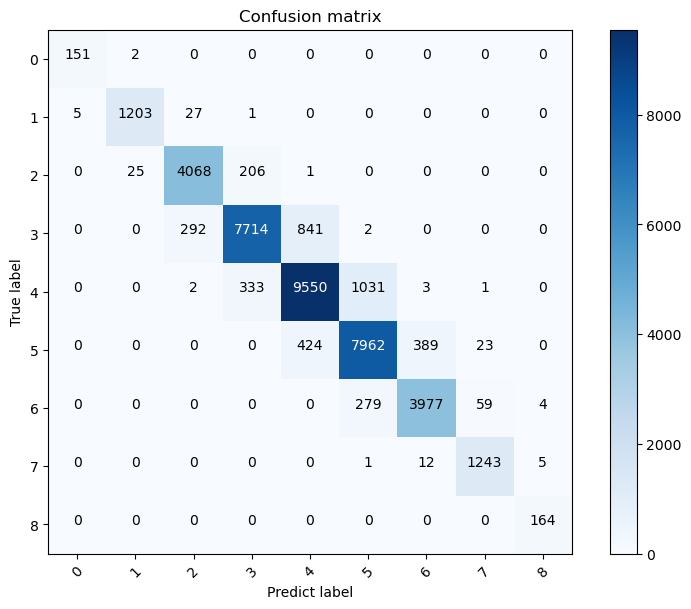

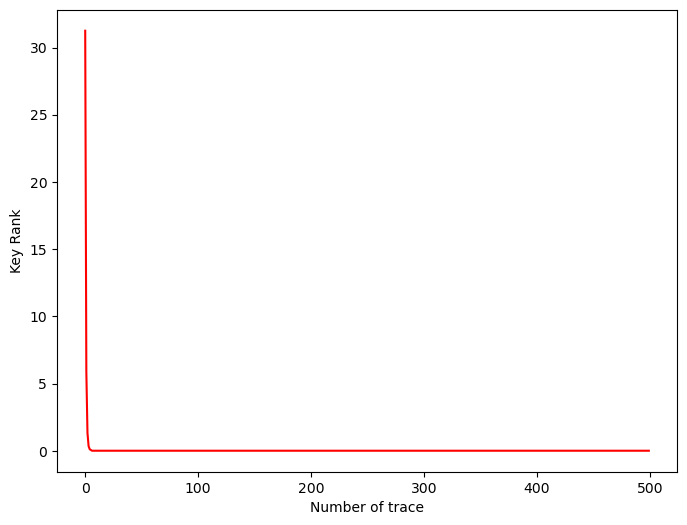

Result on target device:
Target test loss: 22.4366, Target test accuracy: 3402/20000 (17.01%)



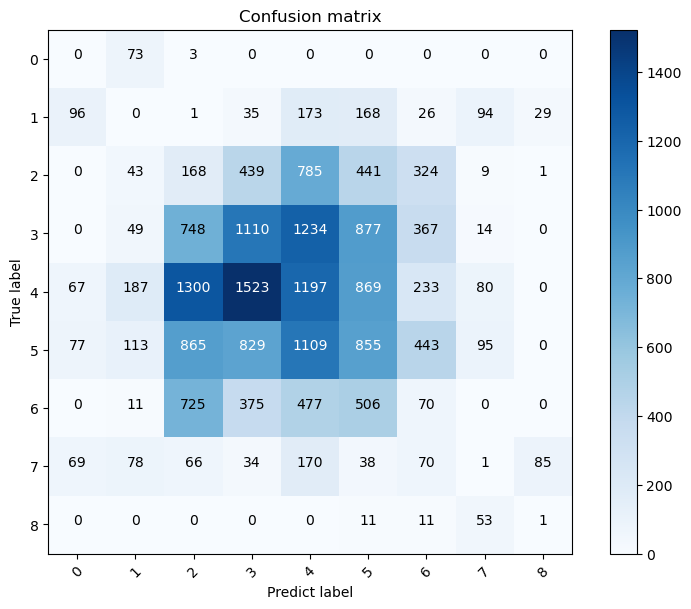

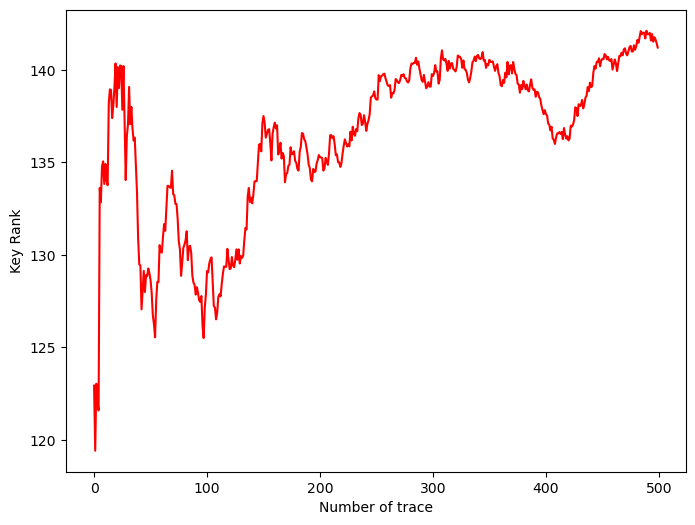

time: 1min


In [8]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
    
# load the pre-trained network
checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
pretrained_dict = checkpoint['model_state_dict']
model.load_state_dict(pretrained_dict)

# evaluate the pre-trained model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id,disp_GE=True,disp_MAT=True, model_flag='pretrained_source')
    print('Result on target device:')
    test(model, target_device_id,disp_GE=True, disp_MAT=True,model_flag='pretrained_target')

# Use shapley value based approach to explain SCA deep learning models 

### Define background data and explainer

In [9]:
import numpy as np
import shap

## select a set of training data as background examples, which use them as expectation value (base value)
num_background_data = 5000
background = X_train_source[np.random.choice(X_train_source.shape[0],num_background_data,replace=False)] # replace=False means a value can only be choose once
print(f"shape of background numpy data {background.shape}")

device = ('cuda' if torch.cuda.is_available() else 'cpu')
background = torch.tensor(np.expand_dims(background,axis=1).astype(np.float32)).to(device)
print(f"shape of background tensor data {background.shape}")

## define and get explainer 
e = shap.DeepExplainer(model,background)

shape of background numpy data (5000, 1000)
shape of background tensor data torch.Size([5000, 1, 1000])
time: 543 ms


## Same-Device: training and testing data from same device (follow same distribution)

### Get shapley values for a single test sample 

In [10]:
# get test sample randomly
test_sample = X_attack_source[np.random.choice(X_attack_source.shape[0],1,replace=False)]
print(f"shape of test sample numpy data {test_sample.shape}")
test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
print(f"shape of test sample tensor data {test_sample_tensor.shape}")

# shapley value
shap_values = e.shap_values(test_sample_tensor)
print(f"shap_values shape {np.array(shap_values).shape}")

## visualize results based on positive and negative values
"""
## e.expected_value: the mean prediction of model in terms of background data, 
where index 0 is the expected value for the predicted class with highest score based on background data
## shap_values.shape=[num_class,batch_size,1,size_of_each_sample]
## shap_values[0]--> index at 0 is the predicted label with highest score
"""
shap.initjs() # init the JS visualization code
shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value

shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_values shape (9, 1, 1, 1000)


time: 6.28 s


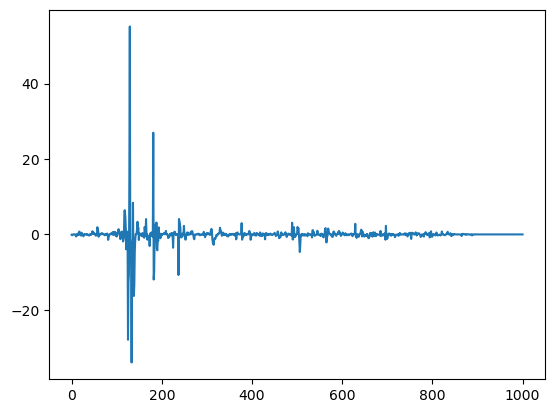

time: 59.3 ms


In [11]:
import matplotlib.pyplot as plt

## visualize reuslts global
x=np.linspace(0,len(shap_values[0][0][0]),len(shap_values[0][0][0]),dtype=int)
plt.plot(x,shap_values[0][0][0])
plt.show()

(1, 1000)
(1, 1000)


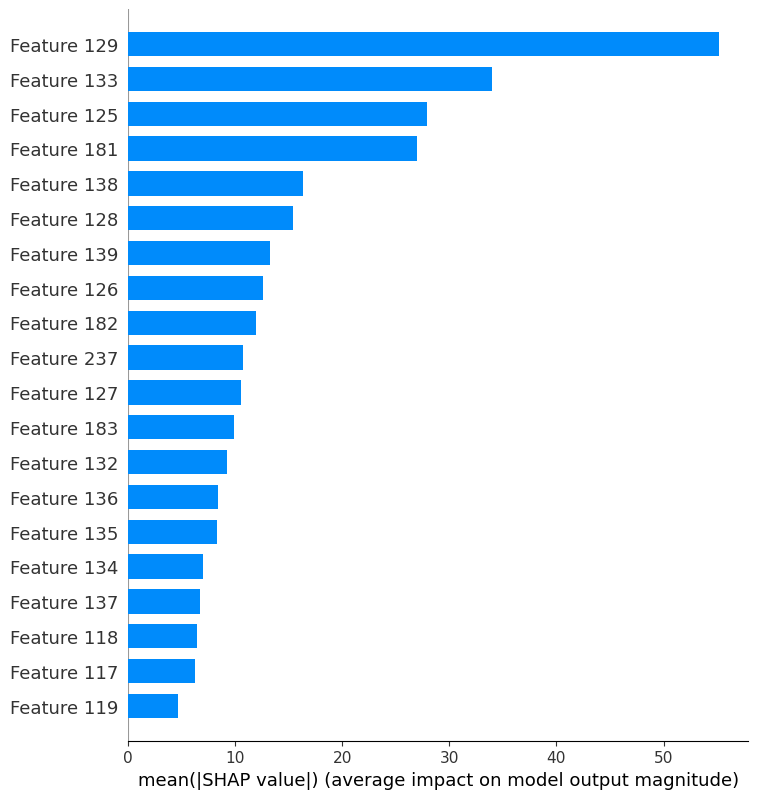

time: 131 ms


In [12]:
## plot the abs value of shap values of each feature
## however, we can not tell whether the feature with highest value has a positive effect or negative effect 
## as this plot take the absolute shapley value for each feature, 

print(shap_values[0][0].shape)
print(test_sample.shape)
shap.summary_plot(shap_values[0][0], test_sample, plot_type="bar")

### Get shapley values for mutiple test sample and save results in path 

In [ ]:
## get shapley values for mutiple test sample and save results in path 
from pathlib import Path
import matplotlib.pyplot as plt 
import pandas as pd
import copy

## define number of test
num_test = 1000
seperate_plot = False

## define folder to save results
Path(f"./results/explain_ai/sjtu/").mkdir(parents=True,exist_ok=True)

## define figure plot and save function
def shap_values_plot(x=None,y=None,output_file=None,y_limit=False):
    if x == None:
        x=np.linspace(0,len(y),len(y),dtype=int)
    plt.plot(x,y)
    if y_limit:
        plt.ylim(-10,10)
    plt.savefig(f"./results/explain_ai/sjtu/{output_file}")
    print(f"results save in './results/explain_ai/sjtu/{output_file}'")
    plt.show()

## get test results
shap_values_sum = np.zeros(X_attack_source.shape[-1])
for i in range(num_test):
    # get test sample randomly
    test_sample = X_attack_source[np.random.choice(X_attack_source.shape[0],1,replace=False)]
    print(f"shape of test sample numpy data {test_sample.shape}")
    test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
    print(f"shape of test sample tensor data {test_sample_tensor.shape}")
    
    # shapley value
    shap_values = e.shap_values(test_sample_tensor)
    print(f"shap_values shape {np.array(shap_values).shape}")
    shap_values_sum += shap_values[0][0][0]
    
    # visualize results
    #shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value
    if seperate_plot:
        output_file = f"model_pred_explaination_same_device_{i}.png"
        print(f"visual shape {shap_values[0][0][0].shape}")
        shap_values_plot(y=shap_values[0][0][0],output_file=output_file)
    
## get the average shapley values and plot
shap_values_avg = shap_values_sum / num_test
shap_values_avg_df = pd.DataFrame(shap_values_avg)
shap_values_avg_df.to_csv('./results/explain_ai/sjtu/avg_shapley_values_same_device.csv',index=False)
shap_values_plot(y=shap_values_avg,output_file='model_pred_explaination_same_device_avg.png',y_limit=True)
shap_values_same_device = copy.deepcopy(shap_values_avg)

shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy data (1, 1000)
shape of test sample tensor data torch.Size([1, 1, 1000])
shap_values shape (9, 1, 1, 1000)
shape of test sample numpy d

In [ ]:
# ## mutiple samples in one figure

# # init the JS visualization code
# shap.initjs()


# test_sample = X_attack_source[np.random.choice(X_attack_source.shape[0],50,replace=False)]
# test_sample = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
# shap_values = e.shap_values(test_sample)

# print(test_sample.shape)
# tt = np.squeeze(test_sample.detach().cpu().numpy(),axis=1)
# print(tt.shape)

# ## e.expected_value: the mean prediction of model in terms of background data
# ## shap_values.shape[num_class,batch_size,1,size_of_each_sample]
# ## shap_values[0]--> index at 0 is the predicted label with highest score
# shap.force_plot(e.expected_value[0], shap_values[0], tt)

## Cross-Device: training and testing data from different device (following different distribution)

### Get shapley values for a single test sample 

In [ ]:
# get test sample randomly
test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
print(f"shape of test sample numpy data {test_sample.shape}")
test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
print(f"shape of test sample tensor data {test_sample_tensor.shape}")

# shapley value
shap_values = e.shap_values(test_sample_tensor)
print(f"shap_values shape {np.array(shap_values).shape}")

## visualize results based on positive and negative values
"""
## e.expected_value: the mean prediction of model in terms of background data, 
where index 0 is the expected value for the predicted class with highest score based on background data
## shap_values.shape=[num_class,batch_size,1,size_of_each_sample]
## shap_values[0]--> index at 0 is the predicted label with highest score
"""
shap.initjs() # init the JS visualization code
shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value

In [ ]:
import matplotlib.pyplot as plt

## visualize reuslts global
x=np.linspace(0,len(shap_values[0][0][0]),len(shap_values[0][0][0]),dtype=int)
plt.plot(x,shap_values[0][0][0])
plt.show()

In [ ]:
## plot the abs value of shap values of each feature
## however, we can not tell whether the feature with highest value has a positive effect or negative effect 
## as this plot take the absolute shapley value for each feature, 

print(shap_values[0][0].shape)
print(test_sample.shape)
shap.summary_plot(shap_values[0][0], test_sample, plot_type="bar")

### Get shapley values for mutiple test sample and save results in path 

In [ ]:
## get shapley values for mutiple test sample and save results in path 
from pathlib import Path
import matplotlib.pyplot as plt 
import copy 
import pandas as pd

## define number of test
num_test = 1000
seperate_plot = False

## define folder to save results
Path(f"./results/explain_ai/sjtu/").mkdir(parents=True,exist_ok=True)

## define figure plot and save function
def shap_values_plot(x=None,y=None,output_file=None,y_limit=False):
    if x == None:
        x=np.linspace(0,len(y),len(y),dtype=int)
    plt.plot(x,y)
    if y_limit:
        plt.ylim(-10,10)
    plt.savefig(f"./results/explain_ai/sjtu/{output_file}")
    print(f"results save in './results/explain_ai/sjtu/{output_file}'")
    plt.show()

## get test results
shap_values_sum = np.zeros(X_attack_source.shape[-1])
for i in range(num_test):
    # get test sample randomly
    test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
    print(f"shape of test sample numpy data {test_sample.shape}")
    test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
    print(f"shape of test sample tensor data {test_sample_tensor.shape}")
    
    # shapley value
    shap_values = e.shap_values(test_sample_tensor)
    print(f"shap_values shape {np.array(shap_values).shape}")
    
    shap_values_sum += shap_values[0][0][0]
    
    # visualize results
    #shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value
    if seperate_plot:
        output_file = f"model_pred_explaination_cross_device_{i}.png"
        print(f"visual shape {shap_values[0][0][0].shape}")
        shap_values_plot(y=shap_values[0][0][0],output_file=output_file)
    
## get the average shapley values and plot
shap_values_avg = shap_values_sum / num_test
shap_values_avg_df = pd.DataFrame(shap_values_avg)
shap_values_avg_df.to_csv('./results/explain_ai/sjtu/avg_shapley_values_cross_device.csv',index=False)
shap_values_plot(y=shap_values_avg,output_file='model_pred_explaination_cross_device_avg.png',y_limit=True)
shap_values_cross_device = copy.deepcopy(shap_values_avg)

# Test Fine-Tuned model in Cross-Device scenario 

### Fine-Tunning

In [ ]:
fine_tune = True

In [ ]:
if fine_tune:
    # create a network
    CDP_model = CDP_Net(num_classes=class_num)
    print('Construct model complete')
    if cuda:
        CDP_model.cuda()
    # initialize a big enough loss
    min_loss = 1000
    # load the pre-trained model
    checkpoint = torch.load('./models/pre-trained_device{}.pth'.format(source_device_id))
    pretrained_dict = checkpoint['model_state_dict']
    CDP_model.load_state_dict(pretrained_dict)
    optimizer = optim.Adam([
            {'params': CDP_model.features.parameters()},
            {'params': CDP_model.classifier_1.parameters()},
            {'params': CDP_model.final_classifier.parameters()}
        ], lr=lr)
    # restore the optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for epoch in range(1, finetune_epoch + 1):
        print(f'Train Epoch {epoch}:')
        CDP_train(epoch, CDP_model)
        with torch.no_grad():
            valid_loss = CDP_validation(CDP_model)
            if valid_loss < min_loss:
                min_loss = valid_loss
                torch.save({
                'epoch': epoch,
                'model_state_dict': CDP_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, './models/best_valid_loss_finetuned_device{}_to_{}.pth'.format(source_device_id, target_device_id))
    torch.save({
        'epoch': epoch,
        'model_state_dict': CDP_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, './models/last_valid_loss_finetuned_device{}_to_{}.pth'.format(source_device_id, target_device_id))

### Performance of Fine-Tuned model

In [ ]:
# create a network
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()
# load the fine-tuned model
checkpoint = torch.load('./models/last_valid_loss_finetuned_device{}_to_{}.pth'.format(source_device_id, target_device_id))
finetuned_dict = checkpoint['model_state_dict']
model.load_state_dict(finetuned_dict)
print('Results after fine-tuning:')
# evaluate the fine-tuned model on source and target domain
with torch.no_grad():
    print('Result on source device:')
    test(model, source_device_id,disp_GE=True, disp_MAT=True,model_flag='finetuned_source')
    print('Result on target device:')
    test(model, target_device_id, disp_GE=True,disp_MAT=True,model_flag='finetuned_target')

# Explainable AI analysis: Fine-Tuning in Cross-Device case

### Define explainer 

In [ ]:
## define and get explainer 
e = shap.DeepExplainer(model,background)

### Get shapley values for a single test sample 

In [ ]:
# get test sample randomly
test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
print(f"shape of test sample numpy data {test_sample.shape}")
test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
print(f"shape of test sample tensor data {test_sample_tensor.shape}")

# shapley value
shap_values = e.shap_values(test_sample_tensor)
print(f"shap_values shape {np.array(shap_values).shape}")

## visualize results based on positive and negative values
"""
## e.expected_value: the mean prediction of model in terms of background data, 
where index 0 is the expected value for the predicted class with highest score based on background data
## shap_values.shape=[num_class,batch_size,1,size_of_each_sample]
## shap_values[0]--> index at 0 is the predicted label with highest score
"""
shap.initjs() # init the JS visualization code
shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value

In [ ]:
import matplotlib.pyplot as plt

## visualize reuslts global
x=np.linspace(0,len(shap_values[0][0][0]),len(shap_values[0][0][0]),dtype=int)
plt.plot(x,shap_values[0][0][0])
plt.show()

In [ ]:
## plot the abs value of shap values of each feature
## however, we can not tell whether the feature with highest value has a positive effect or negative effect 
## as this plot take the absolute shapley value for each feature, 

print(shap_values[0][0].shape)
print(test_sample.shape)
shap.summary_plot(shap_values[0][0], test_sample, plot_type="bar")

### Get shapley values for mutiple test sample and save results in path 

In [ ]:
## get shapley values for mutiple test sample and save results in path 
from pathlib import Path
import matplotlib.pyplot as plt
import copy
import pandas as pd

## define number of test
num_test = 1000
seperate_plot = False

## define folder to save results
Path(f"./results/explain_ai/sjtu/").mkdir(parents=True,exist_ok=True)

## define figure plot and save function
def shap_values_plot(x=None,y=None,output_file=None,y_limit=False):
    if x == None:
        x=np.linspace(0,len(y),len(y),dtype=int)
    plt.plot(x,y)
    if y_limit:
        plt.ylim(-10,10)
    plt.savefig(f"./results/explain_ai/sjtu/{output_file}")
    print(f"results save in './results/explain_ai/sjtu/{output_file}'")
    plt.show()

## get test results
shap_values_sum = np.zeros(X_attack_source.shape[-1])
for i in range(num_test):
    # get test sample randomly
    test_sample = X_attack_target[np.random.choice(X_attack_target.shape[0],1,replace=False)]
    print(f"shape of test sample numpy data {test_sample.shape}")
    test_sample_tensor = torch.tensor(np.expand_dims(test_sample,axis=1).astype(np.float32)).to(device)
    print(f"shape of test sample tensor data {test_sample_tensor.shape}")
    
    # shapley value
    shap_values = e.shap_values(test_sample_tensor)
    print(f"shap_values shape {np.array(shap_values).shape}")
    
    shap_values_sum += shap_values[0][0][0]
    
    # visualize results
    #shap.force_plot(e.expected_value[0], shap_values[0][0], test_sample) # expected_value[0] --> the first expected value --> match for the first test sample/shap_value
    if seperate_plot:
        output_file = f"model_pred_explaination_cross_device_fine_tune{i}.png"
        print(f"visual shape {shap_values[0][0][0].shape}")
        shap_values_plot(y=shap_values[0][0][0],output_file=output_file)
    
## get the average shapley values and plot
shap_values_avg = shap_values_sum / num_test
shap_values_avg_df = pd.DataFrame(shap_values_avg)
shap_values_avg_df.to_csv('./results/explain_ai/sjtu/avg_shapley_values_cross_device_fine_tune.csv',index=False)
shap_values_plot(y=shap_values_avg,output_file='model_pred_explaination_cross_device_fine_tune_avg.png',y_limit=True)
shap_values_cross_device_fine_tune = copy.deepcopy(shap_values_avg)

#### Plot in same figure with different cases (same divice, cross device, cross device fine-tune)

In [ ]:
import numpy as np 

marker_size = 18
font_size = 18
x = np.linspace(0,len(shap_values_cross_device_fine_tune),len(shap_values_cross_device_fine_tune),dtype=int)
plt.figure(figsize=(8,6),dpi=150)
plt.plot(x, shap_values_same_device, color='red', marker='*', linestyle='--', linewidth=2, markeredgewidth=2,
         fillstyle='none', markersize=marker_size, label='Same Device')
plt.plot(x, shap_values_cross_device, color='blue', marker='^', linestyle='--', linewidth=2, markeredgewidth=2,
         fillstyle='none', markersize=marker_size, label='Cross Device')
plt.plot(x, shap_values_cross_device_fine_tune, color='orange', marker='o', linestyle='--', linewidth=2, markeredgewidth=2,
         fillstyle='none', markersize=marker_size, label='Cross Device Fine-Tune')
plt.xlabel('Features', {'size': font_size})
plt.ylabel('Shapley Values', {'size': font_size})
plt.tick_params(labelsize=font_size)
plt.legend(loc='best', fontsize=font_size)
plt.savefig(f"./results/explain_ai/sjtu/feature_importance_different_cases.png")
plt.show()